In [1]:
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install -U scikit-learn
# !pip install xgboost
# !pip install lightgbm

In [2]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_percentage_error,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("float_format", "{:.4f}".format)
sns.set_style("whitegrid")

In [3]:
RANDOM_STATE = 42

# Data Definition

In [4]:
_data = load_diabetes()

print(_data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [5]:
data = _data["data"]
feature_names = _data["feature_names"]

df = pd.DataFrame(data, columns=feature_names)
df["target"] = _data["target"]

df.head()

age     sex     bmi      bp      s1      s2      s3      s4      s5  \
0  0.0381  0.0507  0.0617  0.0219 -0.0442 -0.0348 -0.0434 -0.0026  0.0199   
1 -0.0019 -0.0446 -0.0515 -0.0263 -0.0084 -0.0192  0.0744 -0.0395 -0.0683   
2  0.0853  0.0507  0.0445 -0.0057 -0.0456 -0.0342 -0.0324 -0.0026  0.0029   
3 -0.0891 -0.0446 -0.0116 -0.0367  0.0122  0.0250 -0.0360  0.0343  0.0227   
4  0.0054 -0.0446 -0.0364  0.0219  0.0039  0.0156  0.0081 -0.0026 -0.0320   

       s6   target  
0 -0.0176 151.0000  
1 -0.0922  75.0000  
2 -0.0259 141.0000  
3 -0.0094 206.0000  
4 -0.0466 135.0000

# EDA

## Correlation

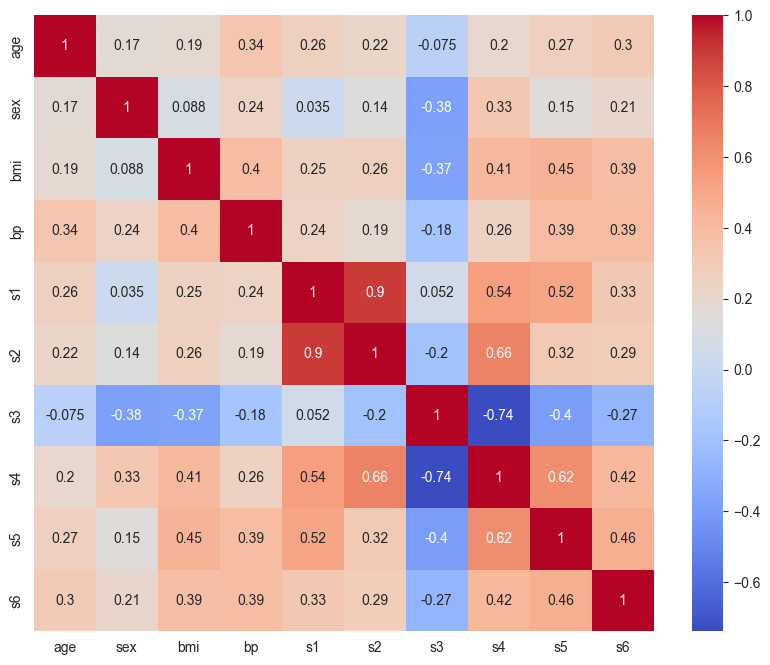

In [6]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    data=df.drop("target", axis=1).corr(),
    annot=True,
    cmap="coolwarm",
)

plt.show()

# Machine Learning Regression

## Decision Tree

[Reference] https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

### Dataset Definition

In [7]:
X = df.drop("target", axis=1)
y = df["target"]

# 먼저 train+valid와 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# train+valid를 다시 train과 valid로 분할 (75:25)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

In [8]:
print(f"데이터 분할 결과:")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Valid: {len(X_valid)} ({len(X_valid)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

데이터 분할 결과:
Train: 264 (59.7%)
Valid: 89 (20.1%)
Test: 89 (20.1%)


### Model (Vanilla)

In [10]:
from sklearn.tree import DecisionTreeRegressor

In [11]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [12]:
model.score(X_train, y_train)

1.0

In [13]:
print(model.intercept_, model.coef_)

AttributeError: 'DecisionTreeRegressor' object has no attribute 'intercept_'

#### Feature Importance

In [14]:
model.feature_importances_

array([0.08981708, 0.00592253, 0.43861624, 0.08517564, 0.04463861,
       0.04418316, 0.05650334, 0.05949104, 0.13289137, 0.04276099])

In [15]:
feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [16]:
_feature_importances = pd.Series(
    model.feature_importances_,
    index=feature_names,
)

_feature_importances

age   0.0898
sex   0.0059
bmi   0.4386
bp    0.0852
s1    0.0446
s2    0.0442
s3    0.0565
s4    0.0595
s5    0.1329
s6    0.0428
dtype: float64

<Axes: >

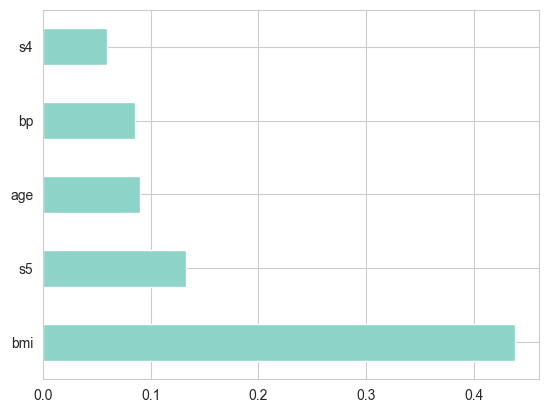

In [17]:
_feature_importances.nlargest().plot(kind="barh")

#### Prediction

In [18]:
# 각 셋에 대한 예측
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

In [19]:
# 각 셋의 성능 평가
def calculate_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return {
        'Set': set_name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

In [20]:
# 모든 셋의 성능 계산
train_metrics = calculate_metrics(y_train, y_train_pred, 'Train')
valid_metrics = calculate_metrics(y_valid, y_valid_pred, 'Valid')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test')

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame([train_metrics, valid_metrics, test_metrics])
results_df = results_df.set_index('Set')

print("=== Train/Valid/Test 셋 성능 비교 ===")
print(results_df.round(4))

=== Train/Valid/Test 셋 성능 비교 ===
           R²       MSE    RMSE   MAPE
Set                                   
Train  1.0000    0.0000  0.0000 0.0000
Valid  0.2095 4330.7978 65.8088 0.3744
Test  -0.2659 6706.9101 81.8957 0.5430


#### Metrics

In [21]:
# 과적합 분석
print(f"\n=== 과적합 분석 ===")
train_valid_r2_diff = train_metrics['R²'] - valid_metrics['R²']
valid_test_r2_diff = valid_metrics['R²'] - test_metrics['R²']

print(f"Train-Valid R² 차이: {train_valid_r2_diff:.4f}")
print(f"Valid-Test R² 차이: {valid_test_r2_diff:.4f}")


=== 과적합 분석 ===
Train-Valid R² 차이: 0.7905
Valid-Test R² 차이: 0.4754


- 임계값 0.1 
    - 아래 코드에서 0.1로 비교하는 것은 고정 규칙이 아니라 경험적 가이드 입니다 
    - 모델/데이터별 차이가 있어 동일 기준으로 일관되게 적용할 수 없습니다 
    - 해당 파일에서는 우선적으로 경험적 가이드를 적용하여 진행합니다 
    
- 객관적 판단을 위해서는 "데이터 기반 임계값" 통한 비교 필요 => (모델 최적화 과정에서 확인) 
    - k-fold에서 val R^2의 표준편차 σ_val을 구해
    - 과적합 : (train_mean - val_mean) > max(0.05, 2*σ_val)
    - 일반화 문제 : |test - val_mean| > 2*σ_val

In [22]:
if train_valid_r2_diff > 0.1:
    print("⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 과적합 위험 낮음: 훈련 데이터와 검증 데이터 간 성능이 유사합니다.")

if valid_test_r2_diff > 0.1:
    print("⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 일반화 성능 양호: 검증 데이터와 테스트 데이터 간 성능이 유사합니다.")

⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.
⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.


In [23]:
# 모델 설명력 해석
print(f"\n=== 모델 설명력 해석 ===")
print(f"훈련 데이터 R²: {train_metrics['R²']:.4f} ({train_metrics['R²']*100:.2f}%)")
print(f"검증 데이터 R²: {valid_metrics['R²']:.4f} ({valid_metrics['R²']*100:.2f}%)")
print(f"테스트 데이터 R²: {test_metrics['R²']:.4f} ({test_metrics['R²']*100:.2f}%)")
print(f"→ 최종 테스트에서 모델이 {test_metrics['R²']*100:.1f}%의 분산을 설명합니다.")


=== 모델 설명력 해석 ===
훈련 데이터 R²: 1.0000 (100.00%)
검증 데이터 R²: 0.2095 (20.95%)
테스트 데이터 R²: -0.2659 (-26.59%)
→ 최종 테스트에서 모델이 -26.6%의 분산을 설명합니다.


In [24]:
# 오차 정확도 해석
print(f"\n=== 오차 정확도 해석 ===")
print(f"Train RMSE: {train_metrics['RMSE']:.2f}")
print(f"Valid RMSE: {valid_metrics['RMSE']:.2f}")
print(f"Test RMSE: {test_metrics['RMSE']:.2f}")
print(f"Test MAPE: {test_metrics['MAPE']:.4f} ({test_metrics['MAPE']*100:.2f}%)")
print(f"→ 최종 테스트에서 예측값이 실제값에 대해 평균적으로 ±{test_metrics['MAPE']*100:.1f}% 정도의 오차를 보입니다.")


=== 오차 정확도 해석 ===
Train RMSE: 0.00
Valid RMSE: 65.81
Test RMSE: 81.90
Test MAPE: 0.5430 (54.30%)
→ 최종 테스트에서 예측값이 실제값에 대해 평균적으로 ±54.3% 정도의 오차를 보입니다.


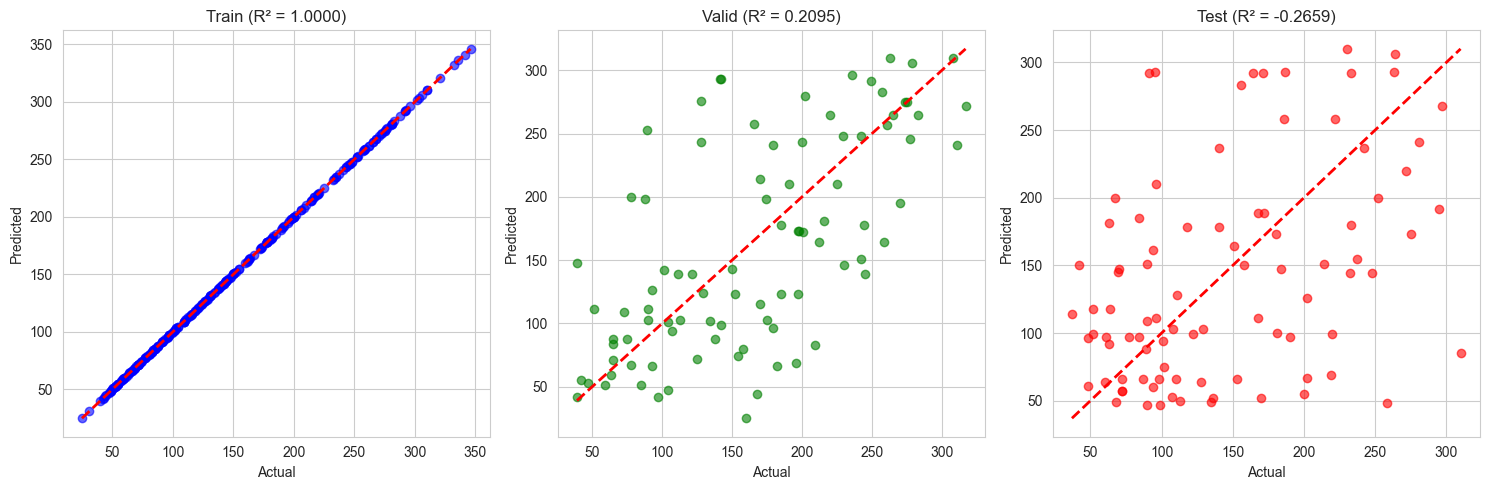

In [25]:
# 시각화: 실제값 vs 예측값 비교
plt.figure(figsize=(15, 5))

# 훈련 데이터
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color="blue")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Train (R² = {train_metrics['R²']:.4f})")

# 검증 데이터
plt.subplot(1, 3, 2)
plt.scatter(y_valid, y_valid_pred, alpha=0.6, color="green")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Valid (R² = {valid_metrics['R²']:.4f})")

# 테스트 데이터
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred, alpha=0.6, color="red")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test (R² = {test_metrics['R²']:.4f})")

plt.tight_layout()
plt.show()

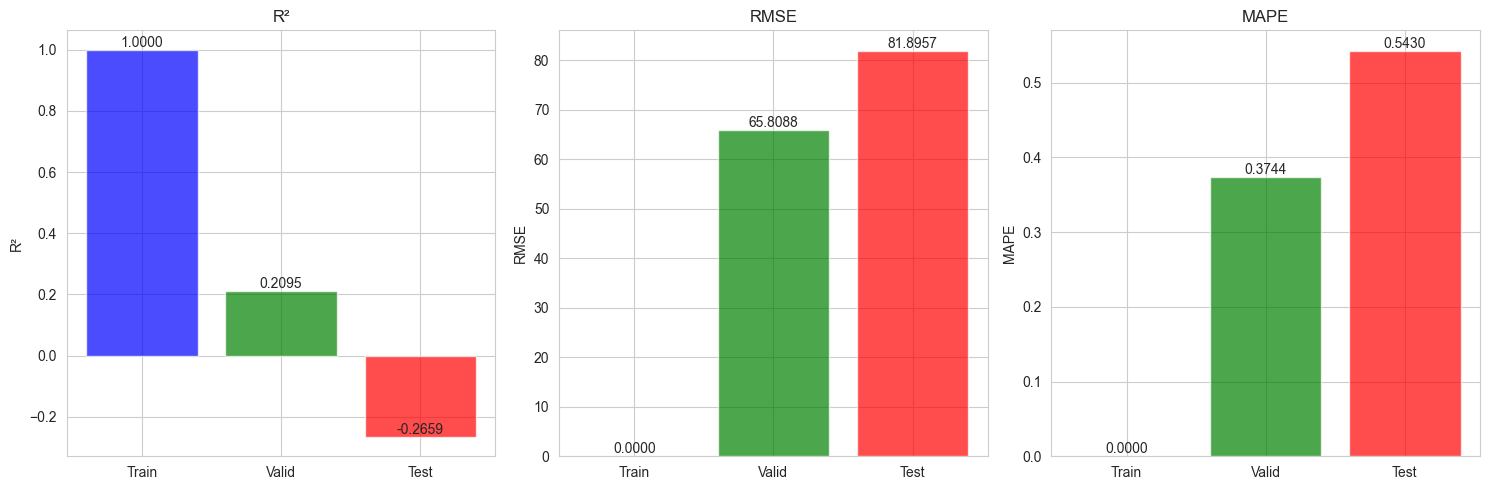

In [26]:
# 성능 지표 비교 차트
metrics_to_plot = ['R²', 'RMSE', 'MAPE']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics_to_plot):
    values = [train_metrics[metric], valid_metrics[metric], test_metrics[metric]]
    sets = ['Train', 'Valid', 'Test']
    
    bars = axes[i].bar(sets, values, color=['blue', 'green', 'red'], alpha=0.7)
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    
    # 값 표시
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

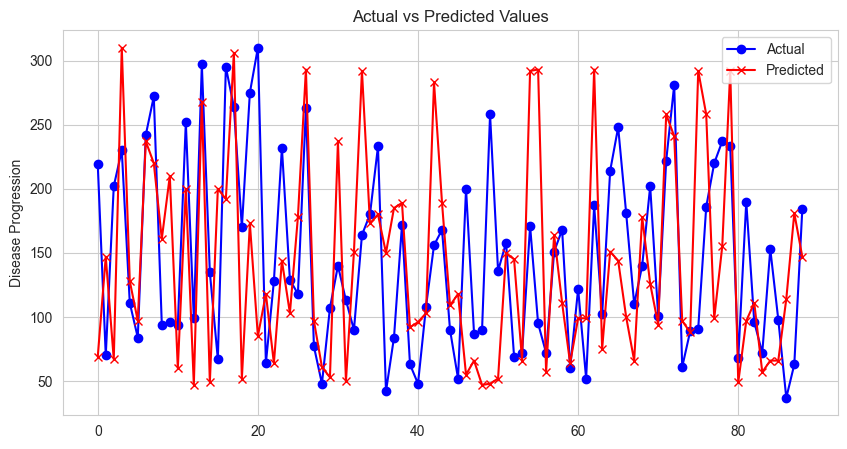

In [27]:
# actual vs predicted
plt.figure(figsize=(10, 5))

plt.plot(y_test.values, label="Actual", marker="o", color="blue")
plt.plot(y_test_pred, label="Predicted", marker="x", color="red")

plt.title("Actual vs Predicted Values")
plt.ylabel("Disease Progression")
plt.legend()
plt.show()

#### Tree Structure

In [28]:
from sklearn.tree import plot_tree

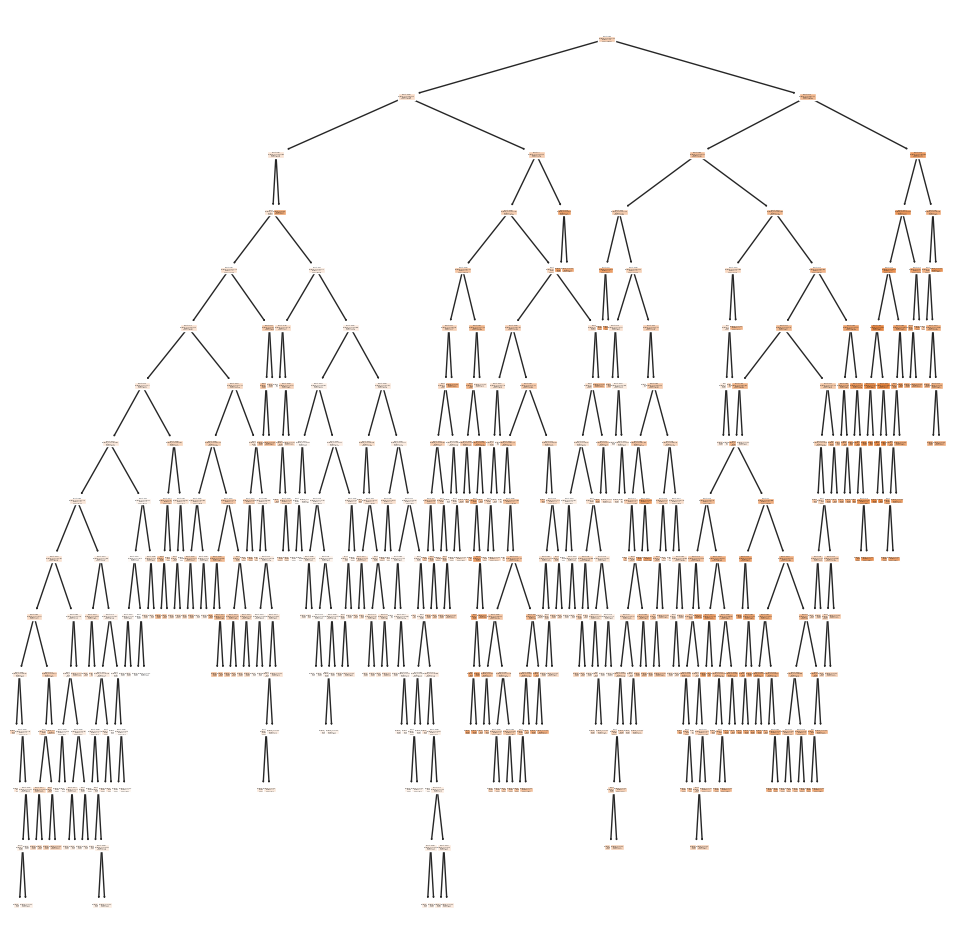

In [29]:
plt.figure(figsize=(12, 12))
plot_tree(model, filled=True)
plt.show()

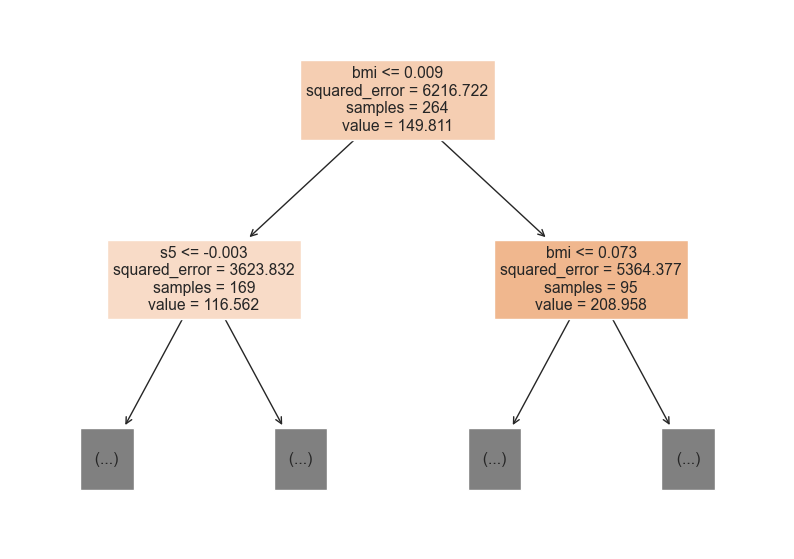

In [30]:
plt.figure(figsize=(10, 7))

plot_tree(
    model,
    filled=True,
    max_depth=1,
    feature_names=feature_names,
)

plt.show()

### Retraining (feat.Prunning)

In [31]:
models = {
    "DecisionTree": DecisionTreeRegressor(
        max_depth=3,          # 트리의 최대 깊이
        min_samples_split=5,  # 노트 분할 시, 최소한 5개의 샘플이 있어야 함
        min_samples_leaf=5,   # 리프 노드에는 최소한 5개의 샘플리 있어야 함
        random_state=RANDOM_STATE,
    )
}

In [32]:
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [33]:
model.score(X_train, y_train)

1.0

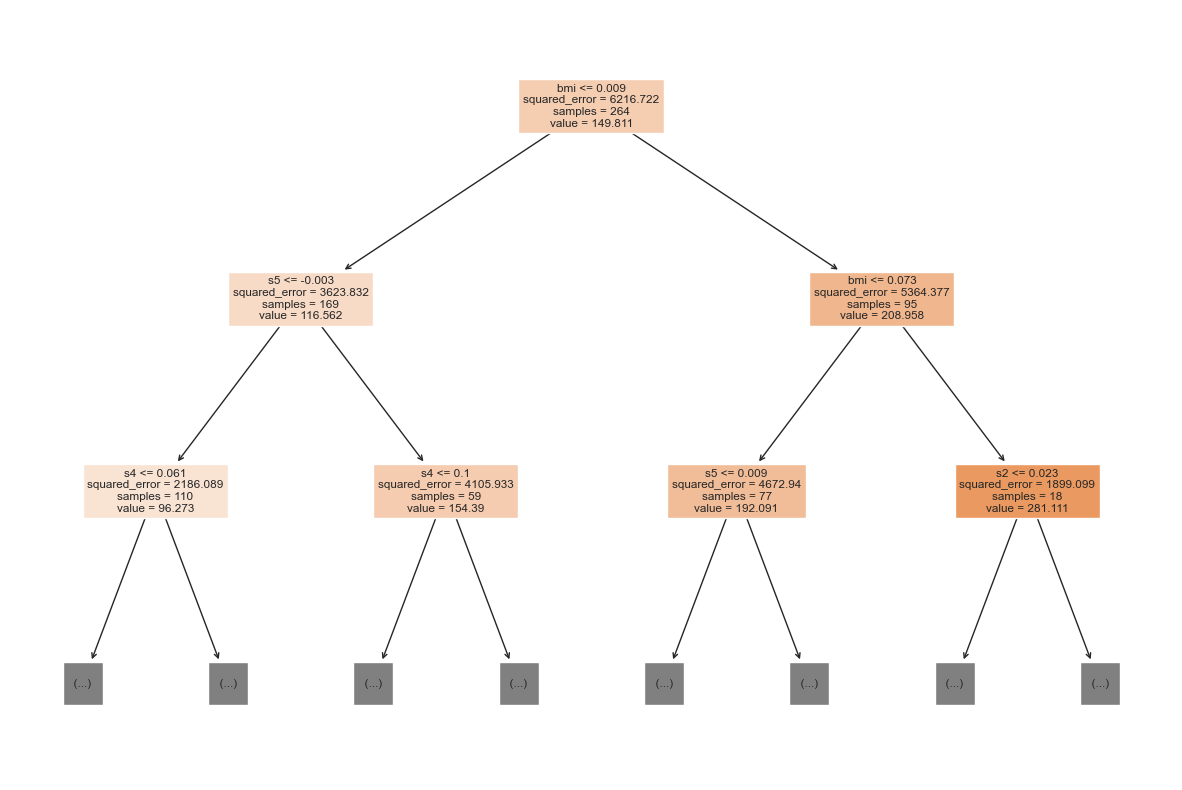

In [34]:
plt.figure(figsize=(15, 10))

plot_tree(
    model,
    filled=True,
    max_depth=2,  # 시각화 위해 제한
    feature_names=feature_names,
)

plt.show()

#### Feature Importance

In [35]:
_feature_importances = pd.Series(
    model.feature_importances_,
    index=feature_names,
)

_feature_importances

age   0.0898
sex   0.0059
bmi   0.4386
bp    0.0852
s1    0.0446
s2    0.0442
s3    0.0565
s4    0.0595
s5    0.1329
s6    0.0428
dtype: float64

<Axes: >

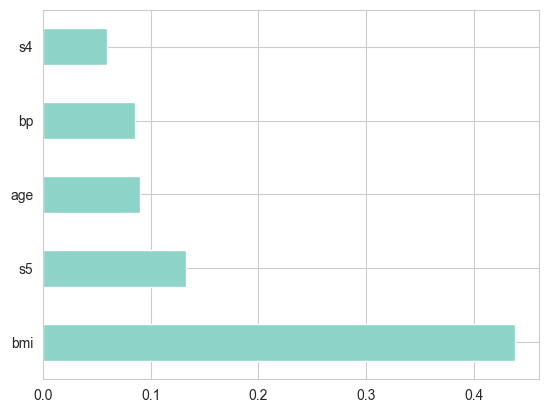

In [36]:
_feature_importances.nlargest().plot(kind="barh")

#### Prediction

In [37]:
# 각 셋에 대한 예측
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

In [38]:
# 모든 셋의 성능 계산
train_metrics = calculate_metrics(y_train, y_train_pred, 'Train')
valid_metrics = calculate_metrics(y_valid, y_valid_pred, 'Valid')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test')

# 결과를 DataFrame으로 정리
results_df = pd.DataFrame([train_metrics, valid_metrics, test_metrics])
results_df = results_df.set_index('Set')

print("=== Train/Valid/Test 셋 성능 비교 ===")
print(results_df.round(4))

=== Train/Valid/Test 셋 성능 비교 ===
           R²       MSE    RMSE   MAPE
Set                                   
Train  1.0000    0.0000  0.0000 0.0000
Valid  0.2095 4330.7978 65.8088 0.3744
Test  -0.2659 6706.9101 81.8957 0.5430


In [39]:
# 과적합 분석
print(f"\n=== 과적합 분석 ===")
train_valid_r2_diff = train_metrics['R²'] - valid_metrics['R²']
valid_test_r2_diff = valid_metrics['R²'] - test_metrics['R²']

print(f"Train-Valid R² 차이: {train_valid_r2_diff:.4f}")
print(f"Valid-Test R² 차이: {valid_test_r2_diff:.4f}")

if train_valid_r2_diff > 0.1:
    print("⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 과적합 위험 낮음: 훈련 데이터와 검증 데이터 간 성능이 유사합니다.")

if valid_test_r2_diff > 0.1:
    print("⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.")
else:
    print("✅ 일반화 성능 양호: 검증 데이터와 테스트 데이터 간 성능이 유사합니다.")


=== 과적합 분석 ===
Train-Valid R² 차이: 0.7905
Valid-Test R² 차이: 0.4754
⚠️  과적합 가능성: 훈련 데이터와 검증 데이터 간 성능 차이가 큽니다.
⚠️  일반화 문제: 검증 데이터와 테스트 데이터 간 성능 차이가 큽니다.


## 여러 알고리즘 결과 확인

(대상) Decision Tree, randomForest, Lasso, Ridge, XGB, LGBM

1. 위 알고리즘 중 가장 최적의 예측 성능을 보이는 알고리즘 확인 
    - 현재 단계에서는 cross validation은 고려하지 않음  
2. 최적의 성능을 보이는 알고리즘의 feature importance 확인 
3. 최적의 모델에 대해서만 예측 성능 확인 (RMSE)

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Models

In [41]:
models = {
    "DecisionTree": DecisionTreeRegressor(
        max_depth=4,              # 트리 최대 깊이 제한으로 과적합 방지
        min_samples_split=10,     # 노드 분할 시 최소 10개 샘플 필요
        min_samples_leaf=5,       # 리프 노드에는 최소 5개 샘플 필요
        random_state=RANDOM_STATE,
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=100,         # 100개의 의사결정 트리로 앙상블 구성
        max_depth=8,              # 개별 트리 최대 깊이 
        min_samples_split=5,      # 노드 분할 시 최소 5개 샘플 필요
        min_samples_leaf=2,       # 리프 노드에는 최소 2개 샘플 필요
        random_state=RANDOM_STATE,
    ),
    "Lasso": Lasso(
        alpha=0.01,               # 정규화 강도 (작을수록 덜 정규화)
        random_state=RANDOM_STATE,
    ),
    "Ridge": Ridge(
        alpha=0.1,                # 정규화 강도 (작을수록 덜 정규화)
        random_state=RANDOM_STATE,
    ),
    "XGBRegressor": XGBRegressor(
        n_estimators=100,         # 100개의 부스팅 라운드
        max_depth=6,              # 트리 최대 깊이
        learning_rate=0.1,        # 학습률 (작을수록 안정적이지만 느림)
        subsample=0.8,            # 샘플링 비율 (과적합 방지)
        colsample_bytree=0.8,     # 특성 샘플링 비율 (과적합 방지) 
        random_state=RANDOM_STATE,
    ),
    "LGBMRegressor": LGBMRegressor(
        n_estimators=100,         # 100개의 부스팅 라운드
        max_depth=6,              # 트리 최대 깊이
        learning_rate=0.1,        # 학습률
        subsample=0.8,            # 샘플링 비율
        colsample_bytree=0.8,     # 특성 샘플링 비율
        random_state=RANDOM_STATE,
        force_col_wise=True,      # 경고 메시지 방지
    ),
}

In [ ]:
# 모든 모델의 성능을 train, valid, test 셋에서 평가


### Metrics

In [ ]:
# 모든 모델의 테스트 성능 기준으로 비교


### Best Model

In [ ]:
# 테스트 성능 기준으로 최고 모델 선택


### Feature Importance

In [ ]:
# Best Model의 feature importance 분석


### Prediction

In [ ]:
# Best Model로 예측 수행


In [ ]:
# Best Model로 성능 계산


In [ ]:
# # actual vs predicted visualization


# End of Documents